 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 9. CNN Basis**
# Section 5. Lenet-5 구성하기

### _Objective_
1. LeNet-5은 1980년대 convolution neural network로 혁신을 가져왔습니다. <br>
2. Tensorflow의 Low-API를 이용하여, LeNet-5을 구성하도록 하겠습니다. <br> 
  
╚══════════════════════════════════════════╝

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tqdm import tqdm

## Graph Visualization

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

<br><br>

# \[ 1. Tensorflow를 이용한 Lenet-5 구성하기 \]

----
----
 
> *아래는 논문에서 발췌한 Lenet-5의 구조도입니다.*<br> 

![Imgur](https://i.imgur.com/WCN9wTP.png)



| 층  | 종류 |필터 갯수 | 필터 크기 | 스트라이드 | 패딩 |
|--- |--- |----| ----|----|----|
| c1 |합성곱| 6   | (5,5) | 1  | valid |
| s2 |pooling| --- | (2,2) | 2  | valid | 
| c3 |합성곱| 16  | (10,10) | 1 | valid |
| s4 |pooling| --- | (2,2) | 2 | valid |
| c5 |합성곱 | 120  | (5,5) | 1  | valid |
| f6 |FC   | 84   | --- | ---  | --- |
| OUT | softmax | 10 |  --- | --- | --- |



<br>

## 1. Tensorflow Graph 구성하기
----

위의 모델은 1980년대 만들어진 모델로, 현대의 딥러닝 발전에 매우 커다란 공헌을 하였습니다.<br>
하지만 현대 딥러닝 모델을 구성할 때의 방식과는 약간씩 다른 부분들이 있습니다.<br>

### (1) placeholder 구성하기

LeNet에서는 Input size가 Mnist 데이터셋의 기본 크기인 (28,28)이 아닌,<br>
여기에 Zero-padding을 더해 32x32 크기로 구성하였습니다.<br>
이는 각 convolution 단계에서 조금씩 이미지가 줄어드는 것을 방지하고자 함이었습니다.<br>


In [0]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32,(None,28,28,1),name='RAW_INPUT')
    
    with tf.variable_scope('padding'):
        paddings = tf.constant([[0,0],[2,2],[2,2],[0,0]])
        x_with_pad = tf.pad(tensor = x, paddings = paddings )
    x_with_pad = tf.identity(x_with_pad,name='INPUT')

tf.pad는 padding을 추가하는 연산입니다.<br>
````python
paddings[D, 0] + tensor.dim_size(D) + paddings[D, 1]
````
의 규칙을 따릅니다. 각 차원 별로 전후 몇개의 padding을 결정합니다.<br>


### (2) C1 구성하기

텐서플로우에서는 convolution 연산자를 지원해줍니다.<br>
````python
tf.nn.conv2d(input, filter, strides, padding,...)
````
으로 구성되어 있습니다. 이때 input과 filter는 아래의 shape 순서를 지켜야 합니다.

1. input : [batch, in_height, in_width, in_channels]
2. filter : [filter_height, filter_width, in_channels, out_channels]

In [4]:
filter_height = 5
filter_width = 5#fix me #
in_channels = 1#fix me #
out_channels = 6#fix me # filter의 갯수임

with graph.as_default():
    with tf.variable_scope('C1'):

        w1 = tf.get_variable(name='w1',
                             shape = [filter_height,filter_width,
                                      in_channels, out_channels],
                             initializer=tf.initializers.glorot_normal)
        b1 = tf.Variable(tf.zeros(shape = [out_channels]))
        
        c1 = tf.nn.conv2d(input = x_with_pad, filter = w1, strides = [1,1,1,1],
                         padding = 'VALID')
        c1 = c1 + b1
        c1 = tf.nn.tanh(c1) #fix me# : activation tanh

W0618 16:07:11.307533 140358502483840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
print("출력의 형태 :",c1.shape)

출력의 형태 : (?, 28, 28, 6)


### (3) S2 구성하기

텐서플로우에서는 pooling 연산자를 지원해줍니다.<br>
논문에서는 average Pooling으로 Max Pooling과 달리 평균값을 이용해주는 기법입니다.<br>
Max Pooling이 좀 더 성능이 좋으므로 변경하겠습니다.
````python
tf.nn.max_pool(value, ksize, strides, padding,...)
````
으로 구성되어 있습니다. 이때 input과 filter는 아래의 shape 순서를 지켜야 합니다.

1. value : [batch, in_height, in_width, in_channels]
2. ksize : 각 차원 별 ksize -> batch 별, 채널 별로 적용하므로 [1,in_height,in_width,1]이 되어야 함

In [0]:
k = 2 # pooling의 크기
with graph.as_default():
    with tf.variable_scope('S2'):
        s2 = tf.nn.max_pool(value = c1, ksize = [1,2,2,1], strides = [1,2,2,1],
                           padding = 'VALID')

In [7]:
print("출력의 형태 :",s2.shape)

출력의 형태 : (?, 14, 14, 6)


### (4) C3 구성하기

C1과 동일하게 구성하여 줍니다.

In [0]:
filter_height = 5
filter_width = 5
in_channels = 6
out_channels = 16

with graph.as_default():
    with tf.variable_scope('C3'):
        w3 = tf.get_variable(name='w3',
                             shape = [filter_height,filter_width,
                                      in_channels,out_channels],
                             initializer=tf.initializers.glorot_normal)
        b3 = tf.Variable(tf.zeros(shape = [out_channels]))
        
        c3 = tf.nn.conv2d(input = s2, filter = w3, strides = [1,1,1,1],
                         padding = 'VALID')
        c3 = c3 + b3
        c3 = tf.nn.tanh(c3)

In [9]:
print("출력의 형태 :",c3.shape)

출력의 형태 : (?, 10, 10, 16)


### (4) S4 구성하기

S2과 동일하게 구성하여 줍니다.

In [0]:
k = 2 # pooling의 크기

with graph.as_default():
    with tf.variable_scope('S4'):
        s4 = tf.nn.max_pool(value = c3, ksize=[1,2,2,1],strides = [1,2,2,1], padding = 'VALID')

In [11]:
print("출력의 형태 :",s4.shape)

출력의 형태 : (?, 5, 5, 16)


### (5) C5 구성하기

C5은 Convolution 연산이지만, 실제로는 Fully Connected Layer와 동일합니다<br>
입력 특징맵의 크기와 Filter의 크기가 동일해, 모두 연결되어 있기 때문입니다.

In [0]:
filter_height = 5 #fix me#
filter_width = 5 #fix me #
in_channels =  16#fix me#
out_channels = 120#fix me#

with graph.as_default():
    with tf.variable_scope('S5'):
        w5 = tf.get_variable(name='w5',
                             shape = [filter_height,filter_width,
                                      in_channels,out_channels],
                             initializer=tf.initializers.glorot_normal)
        b5 = tf.Variable(tf.zeros(shape = [out_channels]))
        
        c5 = tf.nn.conv2d(input = s4, filter = w5, strides = [1,1,1,1],
                         padding = 'VALID')
        c5 = c5 + b5
        c5 = tf.nn.tanh(c5)

In [13]:
print("출력의 형태 :",c5.shape)

출력의 형태 : (?, 1, 1, 120)


### (5) F6 구성하기

F6은 이전에 배웠던 Fully Connected Layer입니다.<Br>
우선 Fully Connected Layer을 적용하기 위해서는 Tensor의 형태를 바꾸어 주어야 합니다.

In [0]:
in_channels = 120
out_channels = 84

with graph.as_default():
    with tf.variable_scope('F6'):
        c5 = tf.reshape(c5, shape = (-1,in_channels))#fix me # : flatten c5 
        f6 = tf.layers.Dense(units=out_channels, activation=tf.nn.tanh,
                             kernel_initializer=tf.initializers.glorot_normal)(c5) #fix me # : dense layer , activation tanh
        


In [15]:
print("출력의 형태 :",f6.shape)

출력의 형태 : (?, 84)


### (6) OUTPUT 구성하기

Original Paper에서는 RBF(Euclidean Radial Basis Function)을 이용하였습니다. <br>
현대 딥러닝에서는 대부분의 분류기 모델에서는 주로 softmax와 Cross-Entropy를 이용하여<br>
학습시킵니다.

In [0]:
num_classes = 10 

with graph.as_default():
    with tf.variable_scope('OUTPUT'):
        logits = tf.layers.Dense(units=num_classes, activation=None,
                                kernel_initializer=tf.initializers.glorot_normal)(f6)
    y_pred = tf.nn.softmax(logits, axis = 1) #fix me# : softmax 
    

In [17]:
print("출력의 형태 :",logits.shape)

출력의 형태 : (?, 10)


### (6) 학습에 필요한 연산자 구현하기 

우리의 출력 활성화함수가 softmax이므로, softmax-cross-entropy를 이용하도록 하겠습니다.<br>
그리고 optimizer도 adam optimizer을 이용하도록 하겠습니다.



In [18]:
with graph.as_default():
    y_true = tf.placeholder(dtype = tf.int64, shape = [None])#fix me#
    lr = tf.placeholder_with_default(input=0.0001, shape=[])#fix me #
    # fix me # use tf.losses.sparse_softmax_cross_entropy()
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y_true, logits=logits)
    
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)#fix me #

W0618 16:07:11.810706 140358502483840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


sparse_softmax_cross_entropy는 y_true 값으로 one-hot vector을 넣는 것이 아닌<br>
class 라벨(ex) 0, 3, 2..)을 넣습니다.

### (7) Metric 구현하기

분류기의 성능을 평가하기 위해, 정확도에 관련된 연산자를 구현하겠습니다.

In [0]:
with graph.as_default():
    with tf.variable_scope('accuracy'):
        pred = tf.math.argmax(y_pred, axis=1) #argmax로 가장큰 prop값의 위치값(=예측정답)
        correct = tf.equal(pred, y_true)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

<br>

## 2. LeNet 학습시키기
----

mnist을 불러와 모델을 학습시키도록 하겠습니다.

### (1) 데이터 가져오기

In [0]:
from tensorflow.keras.datasets.mnist import load_data

(train_X, train_Y), (test_X, test_Y) = load_data()
train_X = train_X/255. # 0~1 정규화
train_X = np.expand_dims(train_X,axis=-1)
test_X = test_X/255. # 0~1 정규화
test_X = np.expand_dims(test_X,axis=-1)

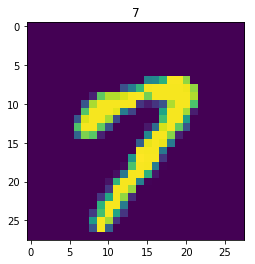

In [21]:
idx = 15
plt.title(train_Y[idx])
plt.imshow(train_X[idx,:,:,0])
plt.show()


### (2) 모델 학습시키기

In [22]:
num_epoch = 10
num_batch = 100
num_step = len(train_X)//num_batch

with graph.as_default():

    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epoch):
        for step in tqdm(range(num_step)):
            batch_X = train_X[step*num_batch:(step+1)*num_batch]
            batch_Y = train_Y[step*num_batch:(step+1)*num_batch]
            sess.run(train_op,feed_dict={
                x:batch_X,
                y_true:batch_Y
            })

        acc = sess.run(accuracy,feed_dict={
            x:test_X,
            y_true:test_Y
        })
        print("[{:2d} epoch] Test 정확도 : {:2.2f}%"
              .format(epoch+1, acc*100))


  8%|▊         | 48/600 [00:00<00:01, 473.28it/s]

[ 1 epoch] Test 정확도 : 91.47%


  8%|▊         | 49/600 [00:00<00:01, 486.22it/s]

[ 2 epoch] Test 정확도 : 94.24%


  8%|▊         | 48/600 [00:00<00:01, 476.99it/s]

[ 3 epoch] Test 정확도 : 95.60%


  8%|▊         | 49/600 [00:00<00:01, 485.93it/s]

[ 4 epoch] Test 정확도 : 96.53%


  8%|▊         | 46/600 [00:00<00:01, 455.66it/s]

[ 5 epoch] Test 정확도 : 97.08%


  8%|▊         | 48/600 [00:00<00:01, 473.11it/s]

[ 6 epoch] Test 정확도 : 97.48%


  8%|▊         | 47/600 [00:00<00:01, 460.96it/s]

[ 7 epoch] Test 정확도 : 97.78%


  8%|▊         | 47/600 [00:00<00:01, 464.57it/s]

[ 8 epoch] Test 정확도 : 98.00%


  8%|▊         | 49/600 [00:00<00:01, 480.86it/s]

[ 9 epoch] Test 정확도 : 98.17%


100%|██████████| 600/600 [00:01<00:00, 476.11it/s]

[10 epoch] Test 정확도 : 98.31%


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/26

---